Dans ce travail je veux utiliser le karnel de Mark Kostiuchenko qu'on peut trouver sur le lien suivant : https://www.kaggle.com/wanakon/kernel24647bb75c

In [1]:
#Declaration des librairies et fonction utilisées
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import timeit
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:




@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [3]:

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

In [4]:
data = main(debug = False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 18s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 23s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 29s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 15s


Ce karnel permet de ressembler les données dans le meme tableau et traiter les catégoriques par une transformation OneHotencoding

In [7]:
data.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.shape

(356251, 798)

In [9]:
# je recuppère uniquement les clients pour lequels la variable target est non null 
df = data[data['TARGET'].notnull()]

In [10]:
df1 = df.replace([np.inf, -np.inf], np.nan)

In [11]:
# Remplacer les valeurs manquantes par la moyenne de chaque colonne
df2 = df1.apply(lambda x: x.fillna(x.mean()),axis=0)

In [12]:
df2.shape

(307507, 798)

# Meilleure modèle pour 10% des données 

In [13]:
data_sample_10 = df2.sample(frac=0.10)

### Sans équilibrage des classes 

In [14]:
percent0 = (data_sample_10['TARGET'].value_counts()[0] / data_sample_10['TARGET'].shape) * 100
percent1 = (data_sample_10['TARGET'].value_counts()[1] / data_sample_10['TARGET'].shape) * 100


print("Nombre d'individus pour la classe 0 :", data_sample_10['TARGET'].value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", data_sample_10['TARGET'].value_counts()[1], ". Soit", percent1, "% de la population.")

Nombre d'individus pour la classe 0 : 28185 . Soit [91.65555592] % de la population.
Nombre d'individus pour la classe 1 : 2566 . Soit [8.34444408] % de la population.


Donc on a bien deux classes non équlibrées 

In [18]:
# je declare mon echantion de données avec la normalisation 
from pycaret.classification import *
clf1 = setup(data = data_sample_10.drop(['index','SK_ID_CURR'],axis=1), target = 'TARGET',normalize = True)

,Description,Value
0,session_id,2849
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(30751, 796)"
5,Missing Values,False
6,Numeric Features,744
7,Categorical Features,51
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
help(get_config)

Help on function get_config in module pycaret.classification:

get_config(variable: str)
    This function retrieves the global variables created when initializing the 
    ``setup`` function. Following variables are accessible:
    
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment par

In [22]:
get_config('X').head(3)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_0,FLAG_DOCUMENT_18_1,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1,PREV_NAME_GOODS_CATEGORY_Animals_MEAN_1.1452667649791692e-06,POS_NAME_CONTRACT_STATUS_XNA_MEAN_0.0,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN_0.0
49959,-0.793340,-0.483768,-0.530069,-0.362182,-0.008159,-1.472203,0.005932,-1.599659,-0.926264,-0.000002,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
304640,2.870972,-0.338687,1.076468,-0.203971,0.716526,0.242355,0.652616,1.282126,1.748466,-0.000002,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
28042,-0.152085,-0.329368,-0.708296,-0.569074,-1.227754,-1.489570,0.005932,1.357768,-0.833345,-0.000002,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [28]:
#df2.isnull().sum()

In [23]:
# je cherche le meilleur modèle pour 10% des données non equilibrés 
best_non_equilibre_10 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9175,0.6965,0.0000,0.0000,0.0000,0.0000,0.0000,5.5020
et,Extra Trees Classifier,0.9175,0.6904,0.0000,0.0000,0.0000,0.0000,0.0000,3.8000
ridge,Ridge Classifier,0.9169,0.0000,0.0051,0.2983,0.0099,0.0072,0.0291,0.2140
gbc,Gradient Boosting Classifier,0.9166,0.7588,0.0332,0.4151,0.0612,0.0501,0.0982,28.3180
lightgbm,Light Gradient Boosting Machine,0.9163,0.7538,0.0411,0.4166,0.0746,0.0611,0.1098,2.7190
ada,Ada Boost Classifier,0.9153,0.7360,0.0518,0.4000,0.0913,0.0738,0.1192,5.6460
lr,Logistic Regression,0.9137,0.7449,0.0631,0.3766,0.1073,0.0853,0.1251,9.3710
knn,K Neighbors Classifier,0.9124,0.5694,0.0214,0.2037,0.0385,0.0234,0.0410,28.2320
lda,Linear Discriminant Analysis,0.9104,0.7474,0.0873,0.3377,0.1377,0.1075,0.1359,2.2230
svm,SVM - Linear Kernel,0.8978,0.0000,0.0974,0.2234,0.1277,0.0854,0.0958,0.9310


le meilleur modèle solon accuracy est 'Random Forest Classifier'  
on remaque une excellent accuracy mais les autres performances sont mauvaises du que les classes sont desequilibrées

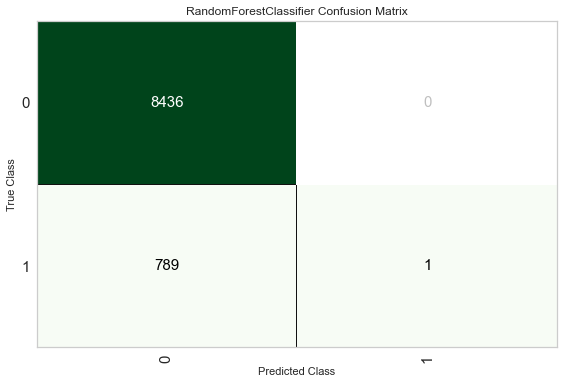

In [24]:
# je vais afficher la mtrice de confusion pour bien voir le desquilibre des classes 
plot_model(best_non_equilibre_10, 'confusion_matrix')

le modèle a predi uniquement des classes 0 car il existe peu des classes 1 

### Equilibrage des classes

In [14]:
from imblearn.under_sampling  import RandomUnderSampler
RUS = RandomUnderSampler()
X_equi,y_equi = RUS.fit_resample(data_sample_10.drop(['TARGET'],axis=1),data_sample_10['TARGET'])

In [15]:
sample_equilibre_10 = pd.concat([X_equi,y_equi],axis = 1)

In [16]:
sample_equilibre_10.to_csv(r'df2.csv')

In [17]:
sample_equilibre_10.head(3)

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT,TARGET
0,78028,190460,1,0,1,0,112500.0,339241.5,10782.0,238500.0,...,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605,0.0
1,136678,258522,0,0,0,0,112500.0,225000.0,11250.0,225000.0,...,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605,0.0
2,160420,285965,0,1,1,1,121500.0,149256.0,15799.5,135000.0,...,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605,0.0


In [18]:
percent0 = (sample_equilibre_10['TARGET'].value_counts()[0] / sample_equilibre_10['TARGET'].shape) * 100
percent1 = (sample_equilibre_10['TARGET'].value_counts()[1] / sample_equilibre_10['TARGET'].shape) * 100


print("Nombre d'individus pour la classe 0 :", sample_equilibre_10['TARGET'].value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", sample_equilibre_10['TARGET'].value_counts()[1], ". Soit", percent1, "% de la population.")

Nombre d'individus pour la classe 0 : 2478 . Soit [50.] % de la population.
Nombre d'individus pour la classe 1 : 2478 . Soit [50.] % de la population.


On remarques les classes actuellement sont bien equilibres 

In [19]:
# je declare mon echantion de données avec la normalisation 
from pycaret.classification import *
equib = setup(data = sample_equilibre_10.drop(['index','SK_ID_CURR'],axis=1), target = 'TARGET',normalize = True)

,Description,Value
0,session_id,778
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(4956, 796)"
5,Missing Values,False
6,Numeric Features,729
7,Categorical Features,66
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
# je cherche le meilleur modèle pour 10% des données non equilibrés 
best_equilibre_10 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6930,0.7644,0.6994,0.6919,0.6949,0.3860,0.3869,4.2950
lightgbm,Light Gradient Boosting Machine,0.6913,0.7598,0.6884,0.6933,0.6903,0.3826,0.3832,1.1840
ada,Ada Boost Classifier,0.6737,0.7320,0.6821,0.6720,0.6764,0.3474,0.3480,0.9820
lr,Logistic Regression,0.6705,0.7180,0.6665,0.6725,0.6692,0.3411,0.3414,1.3940
rf,Random Forest Classifier,0.6702,0.7333,0.6567,0.6762,0.6658,0.3405,0.3411,0.5640
ridge,Ridge Classifier,0.6668,0.0000,0.6619,0.6696,0.6652,0.3335,0.3341,0.0490
et,Extra Trees Classifier,0.6645,0.7260,0.6388,0.6745,0.6559,0.3289,0.3297,0.4980
lda,Linear Discriminant Analysis,0.6624,0.7153,0.6590,0.6647,0.6615,0.3249,0.3252,0.3930
svm,SVM - Linear Kernel,0.6258,0.0000,0.6474,0.6227,0.6340,0.2516,0.2525,0.1590
dt,Decision Tree Classifier,0.5964,0.5964,0.5939,0.5972,0.5951,0.1929,0.1932,0.2680


on remarque que l'equilibrage ameliore significativement les performation du modèle pour 10% des données 

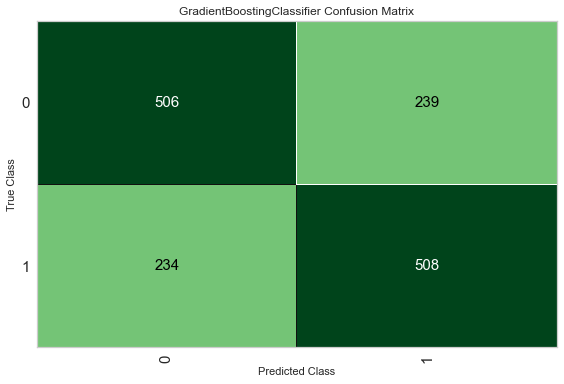

In [23]:
# je vais afficher la mtrice de confusion pour bien voir le desquilibre des classes 
plot_model(best_equilibre_10, 'confusion_matrix')

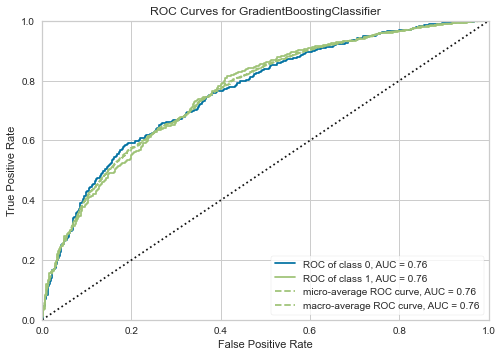

In [24]:
plot_model(best_equilibre_10)

In [25]:
best_equilibre_10

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=778, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### optimisation des parametres du meilleur modèle 

In [38]:
# 
model_gbc_10_equilibre = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6778,0.7423,0.6298,0.6994,0.6628,0.3559,0.3577
1,0.6472,0.7389,0.6409,0.6517,0.6462,0.2945,0.2945
2,0.6602,0.7232,0.6889,0.6526,0.6703,0.3202,0.3207
3,0.7019,0.7680,0.6851,0.7126,0.6986,0.4041,0.4044
4,0.6713,0.7179,0.6851,0.6703,0.6776,0.3425,0.3425
5,0.6908,0.7825,0.7127,0.6862,0.6992,0.3814,0.3817
6,0.6713,0.7473,0.6961,0.6667,0.6811,0.3423,0.3427
7,0.6518,0.7300,0.6188,0.6667,0.6418,0.3040,0.3048
8,0.6546,0.7225,0.6409,0.6629,0.6517,0.3093,0.3095
9,0.7103,0.7838,0.7238,0.7081,0.7158,0.4205,0.4206


In [39]:
tuned_gbc = tune_model(model_gbc_10_equilibre)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6639,0.7276,0.6354,0.6765,0.6553,0.3280,0.3286
1,0.6583,0.7470,0.6630,0.6593,0.6612,0.3166,0.3166
2,0.6797,0.7371,0.7444,0.6601,0.6997,0.3591,0.3621
3,0.7159,0.7846,0.6961,0.7283,0.7119,0.4319,0.4324
4,0.6379,0.6959,0.6243,0.6457,0.6348,0.2759,0.2761
5,0.7187,0.7850,0.7348,0.7151,0.7248,0.4372,0.4373
6,0.6825,0.7487,0.7017,0.6791,0.6902,0.3647,0.3649
7,0.6657,0.7186,0.6354,0.6805,0.6571,0.3318,0.3325
8,0.6490,0.7159,0.6464,0.6536,0.6500,0.2981,0.2981
9,0.6825,0.7679,0.6796,0.6872,0.6833,0.3649,0.3649


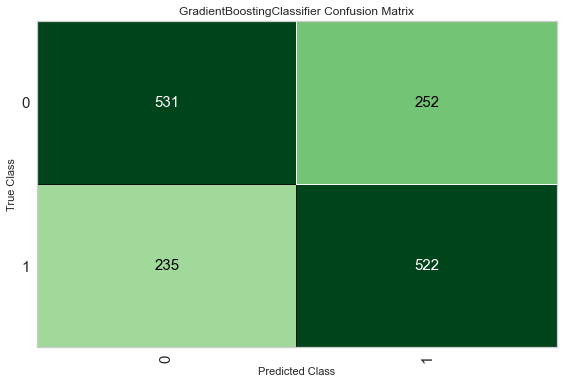

In [41]:
# je vais afficher la mtrice de confusion pour bien voir le desquilibre des classes 
plot_model(tuned_gbc, 'confusion_matrix')

### Meilleure modèle pour 100% des données

In [43]:
full_data = df2

In [44]:
full_data.head(3)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,6.000000
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605


In [47]:
full_data.shape

(307507, 798)

### Sans équilibrage des classes

In [45]:
percent0 = (full_data['TARGET'].value_counts()[0] / full_data['TARGET'].shape) * 100
percent1 = (full_data['TARGET'].value_counts()[1] / full_data['TARGET'].shape) * 100


print("Nombre d'individus pour la classe 0 :", full_data['TARGET'].value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", full_data['TARGET'].value_counts()[1], ". Soit", percent1, "% de la population.")

Nombre d'individus pour la classe 0 : 282682 . Soit [91.92701304] % de la population.
Nombre d'individus pour la classe 1 : 24825 . Soit [8.07298696] % de la population.


In [46]:
# je declare mon echantion de données avec la normalisation 
from pycaret.classification import *
full = setup(data = full_data.drop(['index','SK_ID_CURR'],axis=1), target = 'TARGET',normalize = True)

,Description,Value
0,session_id,3091
1,Target,TARGET
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(307507, 796)"
5,Missing Values,False
6,Numeric Features,756
7,Categorical Features,39
8,Ordinal Features,False
9,High Cardinality Features,False


In [48]:
get_config('X').head(3)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,FLAG_DOCUMENT_13_0,FLAG_DOCUMENT_14_0,FLAG_DOCUMENT_15_1,FLAG_DOCUMENT_16_1,FLAG_DOCUMENT_17_0,FLAG_DOCUMENT_18_0,FLAG_DOCUMENT_19_1,FLAG_DOCUMENT_20_1,FLAG_DOCUMENT_21_1,BURO_CREDIT_TYPE_Interbank credit_MEAN_6.325422532427183e-07
0,0.304911,-0.479081,-0.168044,-0.508431,-0.149373,1.509362,0.825740,0.381706,0.579683,0.001365,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.909214,1.726163,0.590996,1.601673,-1.253665,-0.164309,0.565579,1.079849,1.791907,0.001365,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-0.903697,-1.154395,-1.406920,-1.093893,-0.783943,-0.686987,1.020271,0.208163,0.307281,2.011647,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# je cherche le meilleur modèle pour 100% des données non equilibrés 
best_non_equilibre_100 = compare_models()

IntProgress(value=0, description='Processing: ', max=69)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:09:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


In [2]:
# je vais afficher la mtrice de confusion pour bien voir le desquilibre des classes 
plot_model(best_non_equilibre_100, 'confusion_matrix')

In [ ]:
### Equilibrage des classes

In [ ]:
from imblearn.under_sampling  import RandomUnderSampler
RUS = RandomUnderSampler()
X_equi,y_equi = RUS.fit_resample(data_sample_10.drop(['index','SK_ID_CURR','TARGET'],axis=1),data_sample_10['TARGET'])

In [ ]:
f